In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from time import time
import itk
import SimpleITK as sitk
from itkwidgets import view
from matplotlib import pyplot as plt
%matplotlib inline
from ipywidgets import interact

In [2]:
def CDF(x):
    x=np.sort(x)
    size=x.shape[0]
    y=np.arange(0,size)/size
    return x,y


def setup_download_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if os.path.exists(local_fp):
        print('ALREADY DOWNLOADED FILE')
        return

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(s3_fp, local_fp))
    else:
        run('aws s3 cp {0} {1}'.format(s3_fp, local_fp))

def setup_upload_from_s3(rel_fp, recursive=True):
    s3_fp = 's3://mousebrainatlas-data/' + rel_fp
    local_fp = os.environ['ROOT_DIR'] + rel_fp

    if recursive:
        run('aws s3 cp --recursive {0} {1}'.format(local_fp, s3_fp))
    else:
        run('aws s3 cp {0} {1}'.format(local_fp, s3_fp))

In [3]:
stack = 'MD594'
section = 115
fp = os.path.join('CSHL_data_processed', stack, stack + '_sorted_filenames.txt')
setup_download_from_s3(fp, recursive=False)
with open(os.environ['ROOT_DIR']+fp, 'r') as f:
    fn_idx_tuples = [line.strip().split() for line in f.readlines()]
    section_to_filename = {int(idx): fn for fn, idx in fn_idx_tuples}


fname = os.path.join('CSHL_data_processed', stack, 'Annotation.npy')
setup_download_from_s3(fname, recursive=False)
annotation = np.load(os.environ['ROOT_DIR']+fname, allow_pickle = True, encoding='latin1')
contours = pd.DataFrame(annotation)
contours = contours.rename(columns={0:"name", 1:"section", 2:"vertices"})
contours_grouped = contours.groupby('section')
contours_struc = contours.groupby('name')
valid_sections = np.sort(contours['section'].unique())

ALREADY DOWNLOADED FILE
ALREADY DOWNLOADED FILE


In [4]:
paired_structures = ['5N', '6N', '7N', '7n', 'Amb', 'LC', 'LRt', 'Pn', 'Tz', 'VLL', 'RMC', \
                     'SNC', 'SNR', '3N', '4N', 'Sp5I', 'Sp5O', 'Sp5C', 'PBG', '10N', 'VCA', 'VCP', 'DC']
singular_structures = ['AP', '12N', 'RtTg', 'SC', 'IC']

all_structures = paired_structures + singular_structures

margin = 200/0.46

polygons = [(contour['name'], contour['vertices']) \
            for contour_id, contour in contours_grouped.get_group(section).iterrows()]

In [5]:
raw_images_root = 'CSHL_data_processed/'+stack+'/'+stack+'_prep2_lossless_gray/'
img_fn = raw_images_root + section_to_filename[section] + '_prep2_lossless_gray.tif'
setup_download_from_s3(img_fn, recursive=False)
img = cv2.imread(os.environ['ROOT_DIR']+img_fn, 2)
m, n = img.shape

ALREADY DOWNLOADED FILE


In [10]:
polygon = polygons[0][1].copy()
[left, right, up, down] = [int(max(min(polygon[:, 0]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 0]) + margin), n)),
                           int(max(min(polygon[:, 1]) - margin, 0)),
                           int(min(np.ceil(max(polygon[:, 1]) + margin), m))]

In [12]:
polygon.shape

(42, 2)

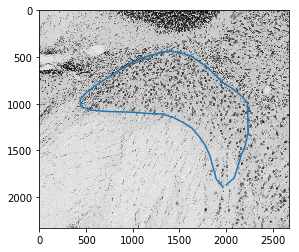

In [14]:
plt.imshow(img[up:down, left:right], cmap='gray')
plt.plot(polygon[:,0]-left, polygon[:,1]-up)

In [15]:
def smooth_and_resample(image, shrink_factors, smoothing_sigmas):
    """
    Args:
        image: The image we want to resample.
        shrink_factor(s): Number(s) greater than one, such that the new image's size is original_size/shrink_factor.
        smoothing_sigma(s): Sigma(s) for Gaussian smoothing, this is in physical units, not pixels.
    Return:
        Image which is a result of smoothing the input and then resampling it using the given sigma(s) and shrink factor(s).
    """
    if np.isscalar(shrink_factors):
        shrink_factors = [shrink_factors]*image.GetDimension()
    if np.isscalar(smoothing_sigmas):
        smoothing_sigmas = [smoothing_sigmas]*image.GetDimension()

    smoothed_image = sitk.SmoothingRecursiveGaussian(image, smoothing_sigmas)
    
    original_spacing = image.GetSpacing()
    original_size = image.GetSize()
    new_size = [int(sz/float(sf) + 0.5) for sf,sz in zip(shrink_factors,original_size)]
    new_spacing = [((original_sz-1)*original_spc)/(new_sz-1) 
                   for original_sz, original_spc, new_sz in zip(original_size, original_spacing, new_size)]
    return sitk.Resample(smoothed_image, new_size, sitk.Transform(), 
                         sitk.sitkLinear, image.GetOrigin(),
                         new_spacing, image.GetDirection(), 0.0, 
                         image.GetPixelID())


    
def multiscale_demons(registration_algorithm,
                      fixed_image, moving_image, initial_transform = None, 
                      shrink_factors=None, smoothing_sigmas=None):
    """
    Run the given registration algorithm in a multiscale fashion. The original scale should not be given as input as the
    original images are implicitly incorporated as the base of the pyramid.
    Args:
        registration_algorithm: Any registration algorithm that has an Execute(fixed_image, moving_image, displacement_field_image)
                                method.
        fixed_image: Resulting transformation maps points from this image's spatial domain to the moving image spatial domain.
        moving_image: Resulting transformation maps points from the fixed_image's spatial domain to this image's spatial domain.
        initial_transform: Any SimpleITK transform, used to initialize the displacement field.
        shrink_factors (list of lists or scalars): Shrink factors relative to the original image's size. When the list entry, 
                                                   shrink_factors[i], is a scalar the same factor is applied to all axes.
                                                   When the list entry is a list, shrink_factors[i][j] is applied to axis j.
                                                   This allows us to specify different shrink factors per axis. This is useful
                                                   in the context of microscopy images where it is not uncommon to have
                                                   unbalanced sampling such as a 512x512x8 image. In this case we would only want to 
                                                   sample in the x,y axes and leave the z axis as is: [[[8,8,1],[4,4,1],[2,2,1]].
        smoothing_sigmas (list of lists or scalars): Amount of smoothing which is done prior to resmapling the image using the given shrink factor. These
                          are in physical (image spacing) units.
    Returns: 
        SimpleITK.DisplacementFieldTransform
    """
    # Create image pyramid.
    fixed_images = [fixed_image]
    moving_images = [moving_image]
    if shrink_factors:
        for shrink_factor, smoothing_sigma in reversed(list(zip(shrink_factors, smoothing_sigmas))):
            fixed_images.append(smooth_and_resample(fixed_images[0], shrink_factor, smoothing_sigma))
            moving_images.append(smooth_and_resample(moving_images[0], shrink_factor, smoothing_sigma))
    
    # Create initial displacement field at lowest resolution. 
    # Currently, the pixel type is required to be sitkVectorFloat64 because of a constraint imposed by the Demons filters.
    if initial_transform:
        initial_displacement_field = sitk.TransformToDisplacementField(initial_transform, 
                                                                       sitk.sitkVectorFloat64,
                                                                       fixed_images[-1].GetSize(),
                                                                       fixed_images[-1].GetOrigin(),
                                                                       fixed_images[-1].GetSpacing(),
                                                                       fixed_images[-1].GetDirection())
    else:
        initial_displacement_field = sitk.Image(fixed_images[-1].GetWidth(), 
                                                fixed_images[-1].GetHeight(),
                                                fixed_images[-1].GetDepth(),
                                                sitk.sitkVectorFloat64)
        initial_displacement_field.CopyInformation(fixed_images[-1])
 
    # Run the registration.            
    initial_displacement_field = registration_algorithm.Execute(fixed_images[-1], 
                                                                moving_images[-1], 
                                                                initial_displacement_field)
    # Start at the top of the pyramid and work our way down.    
    for f_image, m_image in reversed(list(zip(fixed_images[0:-1], moving_images[0:-1]))):
            initial_displacement_field = sitk.Resample (initial_displacement_field, f_image)
            initial_displacement_field = registration_algorithm.Execute(f_image, m_image, initial_displacement_field)
    return sitk.DisplacementFieldTransform(initial_displacement_field)

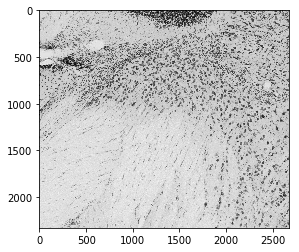

In [86]:
stride = 56
plt.imshow(img[up+stride:down+stride, left:right], cmap='gray')

In [106]:
segmented_img = sitk.GetImageFromArray(img[up:down, left:right])
new_img = sitk.GetImageFromArray(img[up+stride:down+stride, left:right])

In [59]:
polygon[:, 0] = polygon[:, 0] - left
polygon[:, 1] = polygon[:, 1] - up

In [151]:
%%time
demons_filter =  sitk.DiffeomorphicDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(200)
# Regularization (update field - viscous, total field - elastic).
demons_filter.SetSmoothDisplacementField(True)
demons_filter.SetStandardDeviations(0.8)

# create initial transform
initial_tfm = initial_transform = sitk.CenteredTransformInitializer(segmented_img, 
                                                                    new_img, 
                                                                    sitk.Euler2DTransform(), 
                                                                    sitk.CenteredTransformInitializerFilter.GEOMETRY)
# Run the registration.
final_tfm = multiscale_demons(registration_algorithm=demons_filter, 
                              fixed_image = segmented_img,
                              moving_image = new_img,
                              initial_transform = initial_tfm)
#                               shrink_factors = [6,4,2],
#                               smoothing_sigmas = [6,4,2])


CPU times: user 7min 33s, sys: 4.42 s, total: 7min 38s
Wall time: 2min 47s


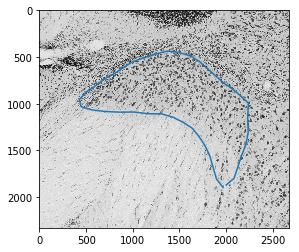

In [152]:
transformed_contour = [new_img.TransformPhysicalPointToContinuousIndex( \
                    final_tfm.TransformPoint(segmented_img.TransformContinuousIndexToPhysicalPoint(p))) \
                       for p in zip(polygon[:,0], polygon[:,1])]
plt.imshow(img[up+stride:down+stride, left:right], cmap='gray')
x_coords, y_coords = zip(*transformed_contour)
plt.plot(np.array(x_coords), np.array(y_coords))

In [153]:
y_coords - polygon[:,1]

array([ 2.98743723, -1.02119215,  0.7258457 , -0.20730007,  6.12043883,
        0.58317572, -1.19277397,  0.17495744, -0.25022282, -0.4204929 ,
        2.59342292, -2.74989822,  3.39806995,  1.04039876, -3.74882408,
       -1.21791249,  1.27631853, -4.86656667,  3.73346986, -7.78241504,
        2.50215657, -3.33280347, -7.47001437,  4.74206038, -1.44115604,
        0.26640424,  1.63080002,  3.0822034 , -2.10338543,  3.58496115,
        1.23851673,  4.19873703,  2.05429094,  1.47648219, -0.95994899,
        3.45809005,  4.07998629,  1.43292951,  3.6974142 , -2.12477889,
        3.01954539,  1.19179436])

In [159]:
PixelType = itk.ctype('float')
fixed_image = itk.GetImageFromArray(img[up:down, left:right].copy())
moving_image = itk.GetImageFromArray(img[up+stride:down+stride, left:right].copy())

In [160]:
# Define our registration components

Dimension = fixed_image.GetImageDimension()
FixedImageType = type(fixed_image)
MovingImageType = type(moving_image)

InternalImageType = itk.Image[itk.F, Dimension]
FixedImageCasterType = itk.CastImageFilter[FixedImageType, InternalImageType]
MovingImageCasterType = itk.CastImageFilter[MovingImageType, InternalImageType]
fixedImageCaster = FixedImageCasterType.New()
movingImageCaster = MovingImageCasterType.New()
fixedImageCaster.SetInput(fixed_image)
movingImageCaster.SetInput(moving_image)

# itk.D is the 'double' C type
TransformType = itk.TranslationTransform[itk.D, Dimension]
initial_transform = TransformType.New()

metric = itk.MeanSquaresImageToImageMetricv4[
    type(fixedImageCaster.GetOutput()), type(movingImageCaster.GetOutput())].New()

In [161]:
fixed_image = fixedImageCaster.GetOutput()
moving_image = movingImageCaster.GetOutput()

In [162]:
# Set up our registration method with its components
from time import time
t0= time()

optimizer = itk.RegularStepGradientDescentOptimizerv4.New(
        learning_rate=4,
        minimum_step_length=0.01,
        relaxation_factor=0.5,
        number_of_iterations=200)

registration = itk.ImageRegistrationMethodv4.New(fixed_image=fixed_image,
        moving_image=moving_image,
        metric=metric,
        optimizer=optimizer,
        initial_transform=initial_transform)

moving_initial_transform = TransformType.New()
initial_parameters = moving_initial_transform.GetParameters()
# X translation
initial_parameters[0] = 0.0
# X translation
initial_parameters[1] = 0.0
moving_initial_transform.SetParameters(initial_parameters)
registration.SetMovingInitialTransform(moving_initial_transform)

identity_transform = TransformType.New()
identity_transform.SetIdentity()
registration.SetFixedInitialTransform(identity_transform)

registration.SetNumberOfLevels(1)
registration.SetSmoothingSigmasPerLevel([0])
registration.SetShrinkFactorsPerLevel([1])

registration.Update()
print(time()-t0)

32.68350076675415


In [163]:
transform = registration.GetTransform()
final_parameters = transform.GetParameters()
x_translation = final_parameters[0]
y_translation = final_parameters[1]

number_of_iterations = optimizer.GetCurrentIteration()

best_value = optimizer.GetValue()

print("Result:")
print(" Translation X = " + str(x_translation))
print(" Translation Y = " + str(y_translation))
print(" Iterations    = " + str(number_of_iterations))
print(" Metric value  = " + str(best_value))

Result:
 Translation X = 0.012992046074800463
 Translation Y = -56.00249638168361
 Iterations    = 30
 Metric value  = 0.010803127438084035


In [169]:
output_transform = itk.CompositeTransform[itk.D, Dimension].New()
output_transform.AddTransform(moving_initial_transform)
output_transform.AddTransform(transform)

resampled_moving_image = itk.resample_image_filter(moving_image,
        transform=output_transform,
        use_reference_image=True,
        default_pixel_value=1,
        reference_image=fixed_image)

In [165]:
transformed_contour = []
for p in zip(polygon[:,0], polygon[:,1]):
    index = itk.ContinuousIndex[itk.D ,Dimension](p)
    transformed_contour.append(moving_image.TransformPhysicalPointToContinuousIndex( \
                        transform.TransformPoint(fixed_image.TransformContinuousIndexToPhysicalPoint(index))))                        

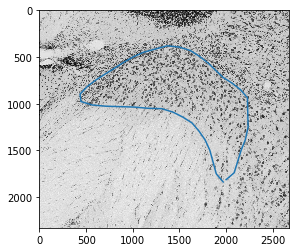

In [166]:
plt.imshow(img[up+stride:down+stride, left:right], cmap='gray')
x_coords, y_coords = zip(*transformed_contour)
plt.plot(np.array(x_coords), np.array(y_coords))

In [167]:
x_coords-polygon[:,0]

array([0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205, 0.01299205, 0.01299205, 0.01299205,
       0.01299205, 0.01299205])

In [168]:
y_coords - polygon[:,1]

array([-56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638, -56.00249638, -56.00249638,
       -56.00249638, -56.00249638])

In [158]:
224*0.46

103.04

In [172]:
difference = itk.subtract_image_filter(fixed_image, resampled_moving_image)

view(difference, ui_collapsed=True)

Viewer(geometries=[], gradient_opacity=0.22, point_sets=[], rendered_image=<itkImagePython.itkImageF2; proxy o…

In [ ]:
itk.